In [120]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импорт для визуализации данных
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme('notebook')
sns.set_palette('Set2')

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# инструмент для разбивки датасета
from sklearn.model_selection import train_test_split

# Для кодирования признаков
import category_encoders as ce

# для оценки положительных и негативных комменатриев
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\grida\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [121]:
# фиксируем RANDOM_SEED чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42

# 1.Постановка проблемы

**Проблема:**

>Одна из проблем компании Booking — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

**Цель проекта:**

>Построить модель машинного обучения, которая предсказывает рейтинг отеля.

**Признаки:**

    * hotel_address - адрес отеля
    * review_date - дата, когда рецензент разместил соответствующий отзыв.
    * average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
    * hotel_name - название отеля
    * reviewer_nationality - национальность рецензента
    * negative_review - отрицательный отзыв, который рецензент дал отелю.
    * review_total_negative_word_counts - общее количество слов в отрицательном отзыв
    * positive_review - положительный отзыв, который рецензент дал отелю
    * review_total_positive_word_counts - общее количество слов в положительном отзыве
    * reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
    * total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
    * total_number_of_reviews - общее количество действительных отзывов об отеле
    * tags - теги, которые рецензент дал отелю.
    * days_since_review - продолжительность между датой проверки и датой очистки
    * additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
    * lat - широта отеля
    * lng - долгота отеля

# 2.Cбор данных

In [122]:
# Загружаем данные
hotels_test = pd.read_csv('data/hotels_test.csv')
hotels_train = pd.read_csv('data/hotels_train.csv')
submission = pd.read_csv('data/submission.csv')

In [123]:
display(hotels_test.head(3))
hotels_test.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393192,2.161520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [124]:
display(hotels_train.head(3))
hotels_train.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845377,2.325643


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

C:\Users\grida\AppData\Local\Temp\ipykernel_16592\3687485835.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


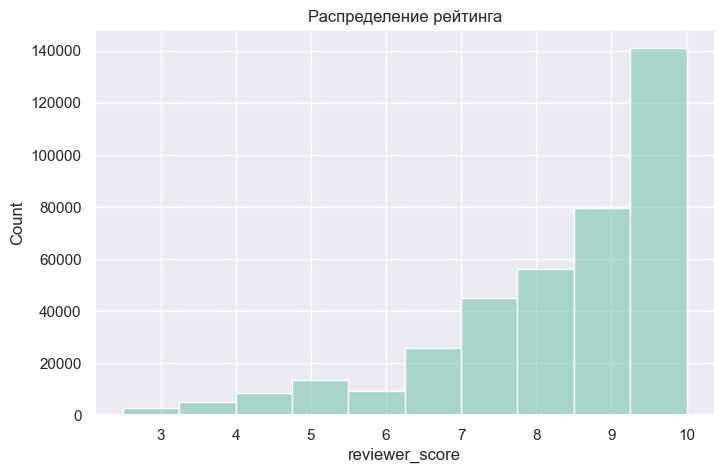

In [125]:
fig = plt.figure(figsize=(8,5))
sns.histplot(
    data=hotels_train,
    x='reviewer_score',
    bins=10,
    palette = 'viridis',
    alpha=0.5,
)
plt.title('Распределение рейтинга');

In [126]:
# сразу проверим и отчистим датасет от дубликатов
print(f"Всего дубликатов: {hotels_train.duplicated().sum()}\n{hotels_train.shape}")

Всего дубликатов: 307
(386803, 17)


In [127]:
hotels_train = hotels_train.drop_duplicates ()
print(f"Всего дубликатов: {hotels_train.duplicated().sum()}\n{hotels_train.shape}")

Всего дубликатов: 0
(386496, 17)


In [128]:
display(submission.head(3))
submission.info()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [129]:
# создадим признак-разделитель 'sample'
hotels_train['sample'] = 1
hotels_test['sample'] = 0

# добавим в hotels_test столбец reviewer_score(пока заполним его 0)
hotels_test['reviewer_score'] = 0

# Объеденим hotels_train и hotels_test в один датасет
hotels = pd.concat([hotels_train, hotels_test], sort = False, ignore_index = True, axis = 0)

In [130]:
display(hotels.head(3))
hotels.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845377,2.325643,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

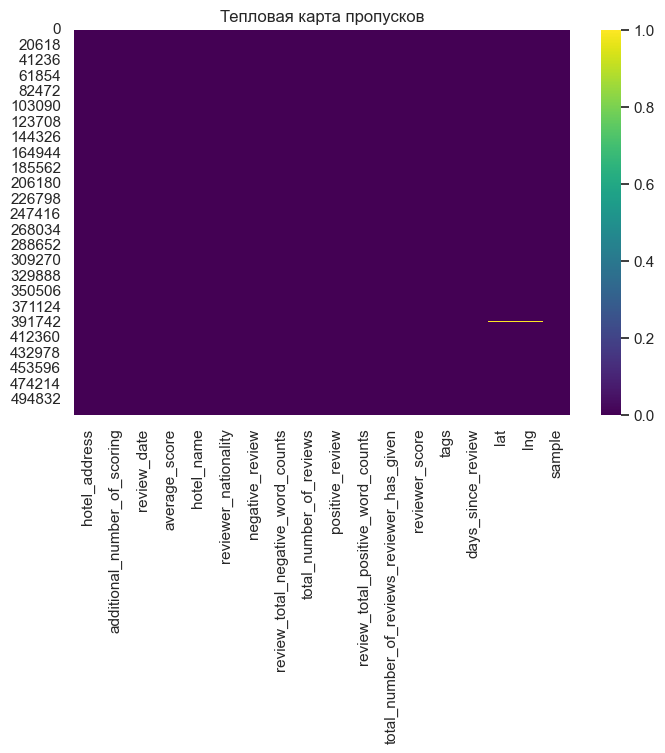

In [131]:
# проверим на наличие пропусков
fig = plt.figure(figsize=(8, 5))
sns.heatmap(hotels.isnull(),cmap = "viridis")
plt.title('Тепловая карта пропусков')
plt.show()

In [132]:
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64

**Первичные выводы:**

>Признаки 'lat' и 'lng' имеют пропуски

>Присутствуют как строковые, так и числовые типы данных

# 3.Очистка данных

In [133]:
# выводим информацию о количестве уникальных значений в пропусках
hotels_isnull = hotels[hotels['lat'].isnull() | hotels['lng'].isnull()]
list_null = hotels_isnull[['hotel_name', 'hotel_address']].value_counts()
display(list_null)

hotel_name                                        hotel_address                                              
Fleming s Selection Hotel Wien City               Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Hotel City Central                                Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
Hotel Atlanta                                     W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
Maison Albar Hotel Paris Op ra Diamond            4 rue de la P pini re 8th arr 75008 Paris France               290
Hotel Daniel Vienna                               Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
Hotel Pension Baron am Schottentor                W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Austria Trend Hotel Schloss Wilhelminenberg Wien  Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Derag Livinghotel Kaiser Franz Joseph Vienna      Sieveringer Stra e 4 

In [134]:
# формируем словари с данными по долготе и широте
dict_lat = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '48.21974808057666', 
                'Holiday Inn Paris Montmartre': '48.889064368690235',
                'Fleming s Selection Hotel Wien City': '48.20949471863499',
                'Hotel Atlanta': '48.2209723965124',
                'Maison Albar Hotel Paris Op ra Diamond': '48.87543722920124',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '48.24608017805536',
                'Hotel City Central': '48.214201786014854',
                'NH Collection Barcelona Podium': '41.39176529029773',
                'City Hotel Deutschmeister': '48.22103057609981',
                'Hotel Daniel Vienna': '48.18897212994251',
                'Roomz Vienna': '48.22382961585223',
                'Hotel Pension Baron am Schottentor': '48.21692824899107',
                'Mercure Paris Gare Montparnasse': '48.84010021974514',
                'Hotel Park Villa': '48.23759024291264',
                'Hotel Advance': '41.38327316014033',
                'Renaissance Barcelona Hotel': '41.394162363243964',
                'Cordial Theaterhotel Wien': '48.20969901650749'}

dict_lng = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '16.285624283904383', 
                'Holiday Inn Paris Montmartre': '2.333206641604505',
                'Fleming s Selection Hotel Wien City': '16.35350997041095',
                'Hotel Atlanta': '16.356650516337886',
                'Maison Albar Hotel Paris Op ra Diamond': '2.3234027262612256',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '16.34202545691955',
                'Hotel City Central': '16.379923233140797',
                'NH Collection Barcelona Podium': '2.1783660658934747',
                'City Hotel Deutschmeister': '16.366622226233126',
                'Hotel Daniel Vienna': '16.3838329415743',
                'Roomz Vienna': '16.393969343883455',
                'Hotel Pension Baron am Schottentor': '16.360055901096636',
                'Mercure Paris Gare Montparnasse': '2.3231778953046462',
                'Hotel Park Villa': '16.34703938556462',
                'Hotel Advance': '2.162964217594162',
                'Renaissance Barcelona Hotel': '2.1748749075722924',
                'Cordial Theaterhotel Wien': '16.351495483903957'}

In [135]:
# заполняем пропуски
hotels['lat'] = hotels.apply(lambda x: dict_lat.get(x['hotel_name']) if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64')
hotels['lng'] = hotels.apply(lambda x: dict_lng.get(x['hotel_name']) if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64')

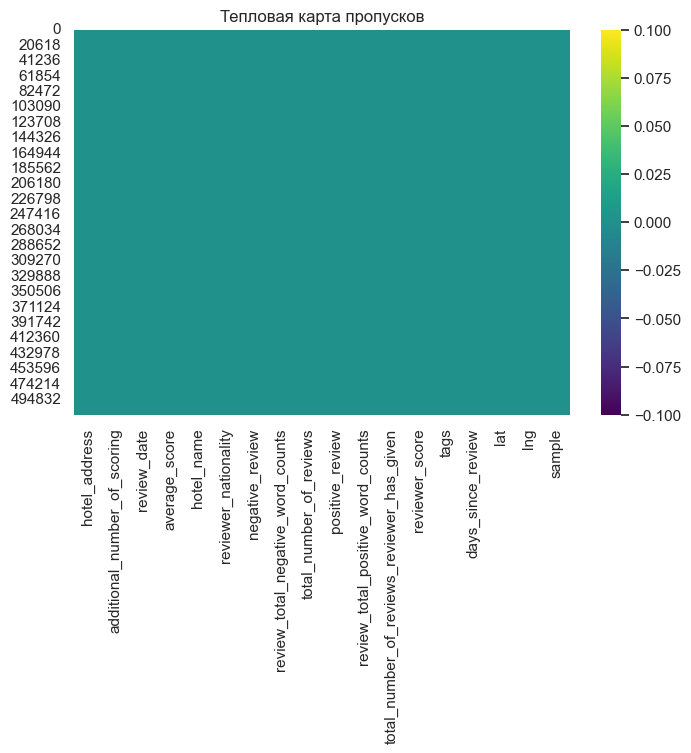

In [136]:
fig = plt.figure(figsize=(8, 5))
sns.heatmap(hotels.isnull(),cmap = "viridis")
plt.title('Тепловая карта пропусков')
plt.show()

# 4.Разведывательный анализ данных (EDA)

In [137]:
train_mask = hotels['sample'] == 1

## hotel_address

In [138]:
uni = hotels['hotel_address'].nunique()
print(f'Уникальных знаений:{uni}')
display(hotels['hotel_address'].iloc[24:29])

Уникальных знаений:1493


24                  8 rue Laferriere 9th arr 75009 Paris France
25          K rntner Ring 8 01 Innere Stadt 1010 Vienna Austria
26                    Balmes 117 Eixample 08008 Barcelona Spain
27    Delflandlaan 15 Slotervaart 1062 EA Amsterdam Netherlands
28        Apollolaan 138 Oud Zuid 1077 BG Amsterdam Netherlands
Name: hotel_address, dtype: object

In [139]:
# Выведем новые признаки страны и города из признака с адрессом
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])
hotels['hotel_city'] = hotels['hotel_address'].apply(
    lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

display(hotels['hotel_country'].value_counts())
display(hotels['hotel_city'].value_counts())

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

>Вероятнее всего новые признаки мультиколлинеарны, проверим это позже

## review_date

In [140]:
# преобразуем review_date в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# выделим 3 новых признака, год, месяц, день
hotels['review_date_year'] = hotels['review_date'].apply(lambda x: x.year)
hotels['review_date_month'] = hotels['review_date'].apply(lambda x: x.month)
hotels['review_date_day'] = hotels['review_date'].apply(lambda x: x.day)

hotels[['review_date_day', 'review_date_month', 'review_date_year']].head()

,review_date_day,review_date_month,review_date_year
0,19,2,2016
1,12,1,2017
2,18,10,2016
3,22,9,2015
4,5,3,2016


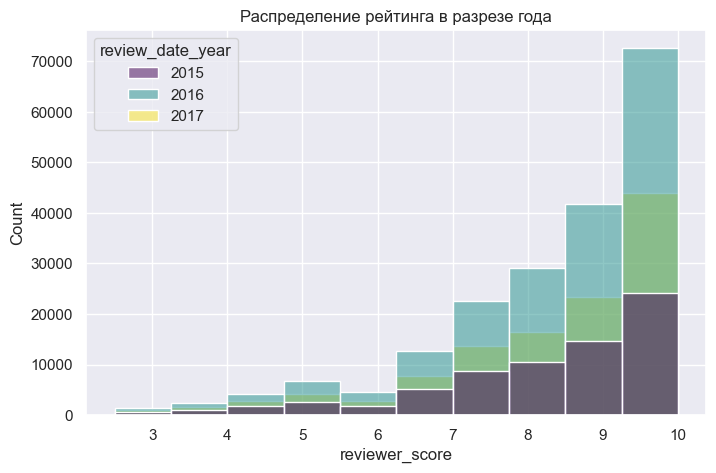

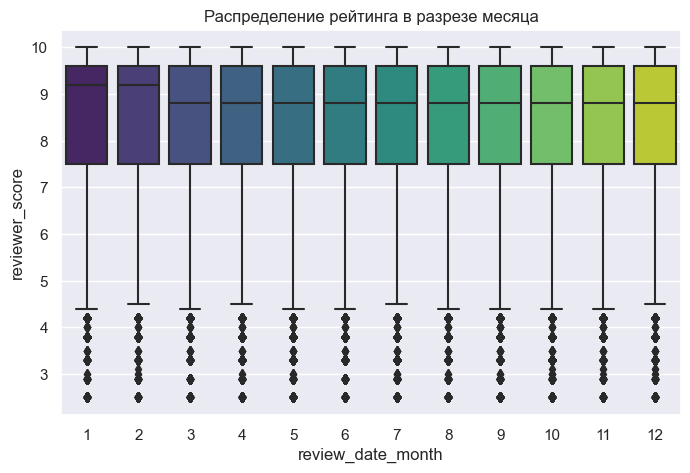

In [141]:
fig = plt.figure(figsize=(8,5))
sns.histplot(
    data=hotels[train_mask],
    x='reviewer_score',
    hue='review_date_year',
    bins=10,
    palette = 'viridis',
    alpha=0.5,
)
plt.title('Распределение рейтинга в разрезе года')

fig = plt.figure(figsize=(8,5))
sns.boxplot(
    data=hotels[train_mask],
    y='reviewer_score',
    x='review_date_month',
    palette = 'viridis'
)
plt.title('Распределение рейтинга в разрезе месяца');

In [142]:
# Выделим приизнак сезона из даты
def seazons(data):
    if data.month in  [3,4,5]:
        return 'spring'
    elif data.month in  [6,7,8]:
        return 'summer'
    elif data.month in  [9,10,11]:
        return 'autumn'
    else:
        return 'winter'

hotels['season'] = hotels['review_date'].apply(seazons)
hotels['season'].value_counts()

summer    142800
spring    130432
autumn    122123
winter    120076
Name: season, dtype: int64

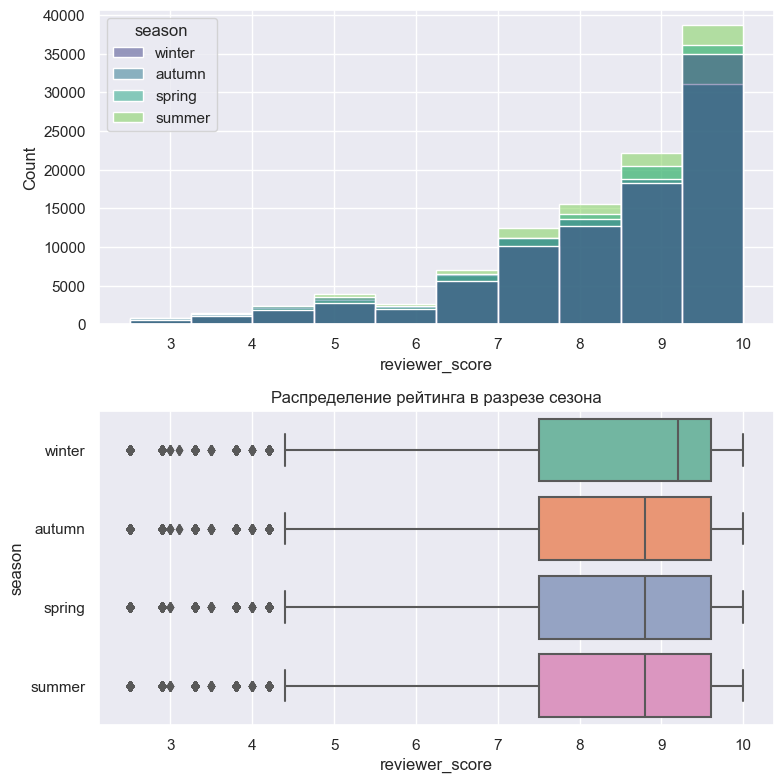

In [143]:
fig, axis = plt.subplots(2,figsize = (8,8))
sns.histplot(
    data=hotels[train_mask],
    x='reviewer_score',
    hue='season',
    bins=10,
    palette = 'viridis',
    alpha=0.5,
    ax=axis[0]
)

sns.boxplot(
    data=hotels[train_mask],
    x='reviewer_score',
    y='season',
    ax=axis[1]
)
plt.title('Распределение рейтинга в разрезе сезона')
plt.tight_layout();

## days_since_review

In [144]:
# преобразуем days_since_review в целочисленный формат
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['days_since_review'].head()

0    531
1    203
2    289
3    681
4    516
Name: days_since_review, dtype: int64

## positive_review и negative_review

In [145]:
hotels[['positive_review','negative_review']].head(3)

,positive_review,negative_review
0,Staff were amazing,Leaving
1,location,poor breakfast
2,No Positive,No kettle in room


In [146]:
# разберемся с признаками negative_review и positive_review, для этого воспользуемся SentimentIntensityAnalyzer
# преобразуем признаки в числовое представление "настроения" оценки 

sid = SentimentIntensityAnalyzer()

hotels['compound_review_pos'] = hotels['positive_review'].apply(
    lambda x: sid.polarity_scores(x)['compound'])
hotels['compound_review_neg'] = hotels['negative_review'].apply(
    lambda x: sid.polarity_scores(x)['compound'])
hotels['compound_review'] = hotels['compound_review_pos'] - hotels['compound_review_neg']

hotels['positive_review'] = hotels['positive_review'].apply(lambda x: sid.polarity_scores(x)['pos'])
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: sid.polarity_scores(x)['neg'])

hotels[['positive_review','negative_review', 'compound_review']].head()

,positive_review,negative_review,compound_review
0,0.655,0.000,0.5859
1,0.000,0.756,0.4767
2,0.621,0.423,0.6360
3,0.721,1.000,1.6265
4,0.382,0.667,1.1003


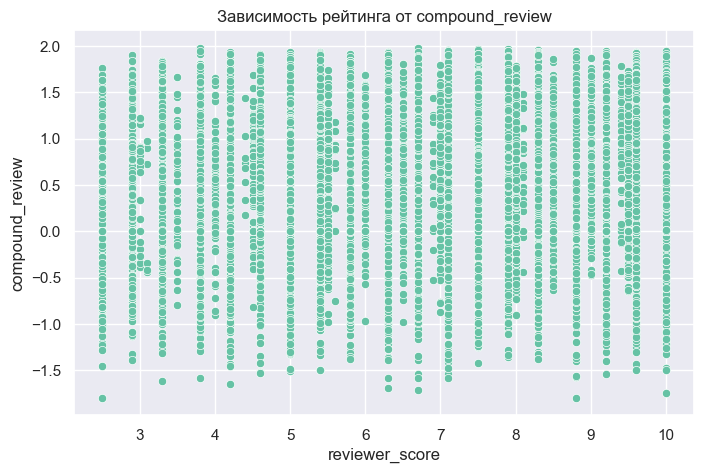

In [147]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=hotels[hotels['sample'] == 1],
    y='compound_review',
    x='reviewer_score'
)
plt.title('Зависимость рейтинга от compound_review');

# Кодирование признаков

## tags

> Разберемся с тегами, попытаемся найти логически связанные теги, самые популярные и преобразуем данные

In [148]:
def string_prepare(string_):
    """Функция получает на вход строку с тегаии через запятую и выводит список тегов.
    Args:
        string_ (str): строка с тегами
    Returns:
        new_list (list): список тегов
    """
    
    new_list = []
    rep_str = string_.replace("[' ", "").replace(" ']", "").replace(" ' ", "").split(" ',")
    for i in rep_str:
        j = i.strip()
        new_list.append(j)
    return new_list

In [149]:
tags_lists = hotels['tags'].apply(string_prepare)
print(tags_lists.iloc[200:210])

200                                                  [Leisure trip, Couple, Classic Double Room, Stayed 4 nights]
201         [Leisure trip, Family with young children, 2 rooms, Stayed 14 nights, Submitted from a mobile device]
202                  [Leisure trip, Couple, Standard Queen Room, Stayed 2 nights, Submitted from a mobile device]
203    [Business trip, Solo traveler, King Room with River View, Stayed 2 nights, Submitted from a mobile device]
204                   [Leisure trip, Couple, Deluxe Double Room, Stayed 4 nights, Submitted from a mobile device]
205                   [Leisure trip, Couple, Deluxe Double Room, Stayed 2 nights, Submitted from a mobile device]
206                  [Leisure trip, Couple, Superior Double Room, Stayed 1 night, Submitted from a mobile device]
207           [Leisure trip, Group, Comfort Double or Twin Room, Stayed 3 nights, Submitted from a mobile device]
208                           [Leisure trip, Group, Double Room, Stayed 2 nights, Submit

In [164]:
# формируем список из 20 первых тегов
tags_list = tags_lists.explode().value_counts().head(20).index.tolist()
tags_list

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room']

> Выделим теги числа проведенных в отеле ночей, типа поездки, а также некторотые наиболее популярные теги из списка выше

In [176]:
import re

trip_type = {}
n_days_stayed = {}
submitted_from = {}

for tags in tags_lists:
    for tag in tags:
        if re.search(r'trip\b', tag.lower()) is not None and tag in trip_type:
            trip_type[tag] += 1
        elif re.search(r'trip\b', tag.lower()) is not None:
            trip_type[tag] = 1
        
        if re.search(r'submitted from\b', tag.lower()) is not None and tag in submitted_from:
            submitted_from[tag] += 1
        elif re.search(r'submitted from\b', tag.lower()) is not None:
            submitted_from[tag] = 1
        
        if re.search(r'stayed\b', tag.lower()) is not None and tag in n_days_stayed:
            n_days_stayed[tag] += 1
        elif re.search(r'stayed\b', tag.lower()) is not None:
            n_days_stayed[tag] = 1
        
        if re.search(r'double room\b', tag.lower()) is not None and tag in double_room_types:
            double_room_types[tag] += 1
        elif re.search(r'double room\b', tag.lower()) is not None:
            double_room_types[tag] = 1
        
        if re.search(r'family\b', tag.lower()) is not None and tag in family_with:
            family_with[tag] += 1
        elif re.search(r'family\b', tag.lower()) is not None:
            family_with[tag] = 1

In [151]:
trip_type

{'Leisure trip': 417538, 'Business trip': 82884}

In [152]:
hotels['leisure_trip'] = hotels['tags'].apply(lambda x:
    1 if 'Leisure trip' in x else 0 )
hotels['business_trip'] = hotels['tags'].apply(lambda x:
    1 if 'Business trip' in x else 0 )

In [153]:
n_days_stayed

{'Stayed 2 nights': 133850,
 'Stayed 1 night': 193568,
 'Stayed 3 nights': 95761,
 'Stayed 6 nights': 9765,
 'Stayed 4 nights': 47777,
 'Stayed 5 nights': 20826,
 'Stayed 8 nights': 2499,
 'Stayed 7 nights': 7391,
 'Stayed 10 nights': 888,
 'Stayed 14 nights': 247,
 'Stayed 19 nights': 29,
 'Stayed 13 nights': 246,
 'Stayed 9 nights': 1293,
 'Stayed 17 nights': 42,
 'Stayed 11 nights': 417,
 'Stayed 27 nights': 11,
 'Stayed 12 nights': 316,
 'Stayed 15 nights': 117,
 'Stayed 21 nights': 23,
 'Stayed 18 nights': 33,
 'Stayed 16 nights': 57,
 'Stayed 26 nights': 7,
 'Stayed 24 nights': 6,
 'Stayed 30 nights': 11,
 'Stayed 22 nights': 10,
 'Stayed 23 nights': 10,
 'Stayed 28 nights': 7,
 'Stayed 20 nights': 19,
 'Stayed 25 nights': 7,
 'Stayed 29 nights': 5,
 'Stayed 31 nights': 1}

In [156]:
def days_stayed(tags):
    """Функция вытягивающая количество ночей из тега, если такой имеется

    Args:
        tags (str): перечень тегов в строковом формате

    Returns:
        nights (int): Число ночей
    """
    tag_list = string_prepare(tags)
    for tag in tag_list:
        if 'Stayed' in tag:
            nights = tag.split(sep=" ")[1]
            return nights
    return 0

In [157]:
hotels['number_of_nights'] = hotels['tags'].apply(days_stayed)

In [195]:
hotels['number_of_nights'] = hotels['number_of_nights'].apply(lambda x: int(x))

In [168]:
submitted_from

{'Submitted from a mobile device': 307470}

In [169]:
hotels['mobile_device'] = hotels['tags'].apply(lambda x:
    1 if 'Submitted from a mobile device' in x else 0 )

In [178]:
# формируем список из оставшихся популярных тегов
tags_list = ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Double Room', 
             'Standard Double Room', 'Superior Double Room', 'Family with older children',
             'Deluxe Double Room', 'Double or Twin Room', 'Standard Double or Twin Room', 'Classic Double Room']

In [179]:
# Пишем функцию для создания новых признаков из признаков tags
def add_tags(data, list):
    for review in list:
        col_name = "tags_" + review.lower()
        data[col_name] = data['tags'].apply(lambda x: 1 if review in x else 0)
    return data

# производим создание бинарных признаков из tags
hotels = add_tags(hotels, tags_list)

## reviewer_nationality

In [180]:
# закодируем признак reviewer_nationality
hotels['reviewer_nationality'].value_counts()

 United Kingdom               245165
 United States of America      35390
 Australia                     21663
 Ireland                       14820
 United Arab Emirates          10230
                               ...  
 Guinea                            1
 Tuvalu                            1
 Comoros                           1
 Anguilla                          1
 Cape Verde                        1
Name: reviewer_nationality, Length: 227, dtype: int64

In [181]:
# уникальных значений много, всего 227, применим двоичное кодировние
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
bin_nationality = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, bin_nationality], axis=1)

## hotel_country и hotel_city

In [182]:
# закодируем признаки hotel_country и hotel_city, как нам уже известно, 
# в данных признаках всего 6 уникальных значений, применим onehotencoder 

one_hot_encoder = ce.OneHotEncoder(cols=['hotel_country'])
one_hot_country = one_hot_encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, one_hot_country], axis=1)

one_hot_encoder = ce.OneHotEncoder(cols=['hotel_city'])
one_hot_city = one_hot_encoder.fit_transform(hotels['hotel_city'])
hotels = pd.concat([hotels, one_hot_city], axis=1)

## season

In [31]:
# закодируем признак сезона, также при помощи onehotencoder

one_hot_encoder = ce.OneHotEncoder(cols=['season'])
one_hot_season = one_hot_encoder.fit_transform(hotels['season'])
hotels = pd.concat([hotels, one_hot_season], axis=1)

In [ ]:
# Избавимся от категориальных признаков, после обработки данных
hotels = hotels.drop(['hotel_address', 'review_date', 'tags', 'hotel_name', 'reviewer_nationality', 'hotel_country', 'hotel_city','season'], axis = 1)

In [197]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   negative_review                             515431 non-null  float64
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   positive_review                             515431 non-null  float64
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   days_since_review                           515431 non-null  int64  
 

## Отбор признаков

C:\Users\grida\AppData\Local\Temp\ipykernel_16592\855120234.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


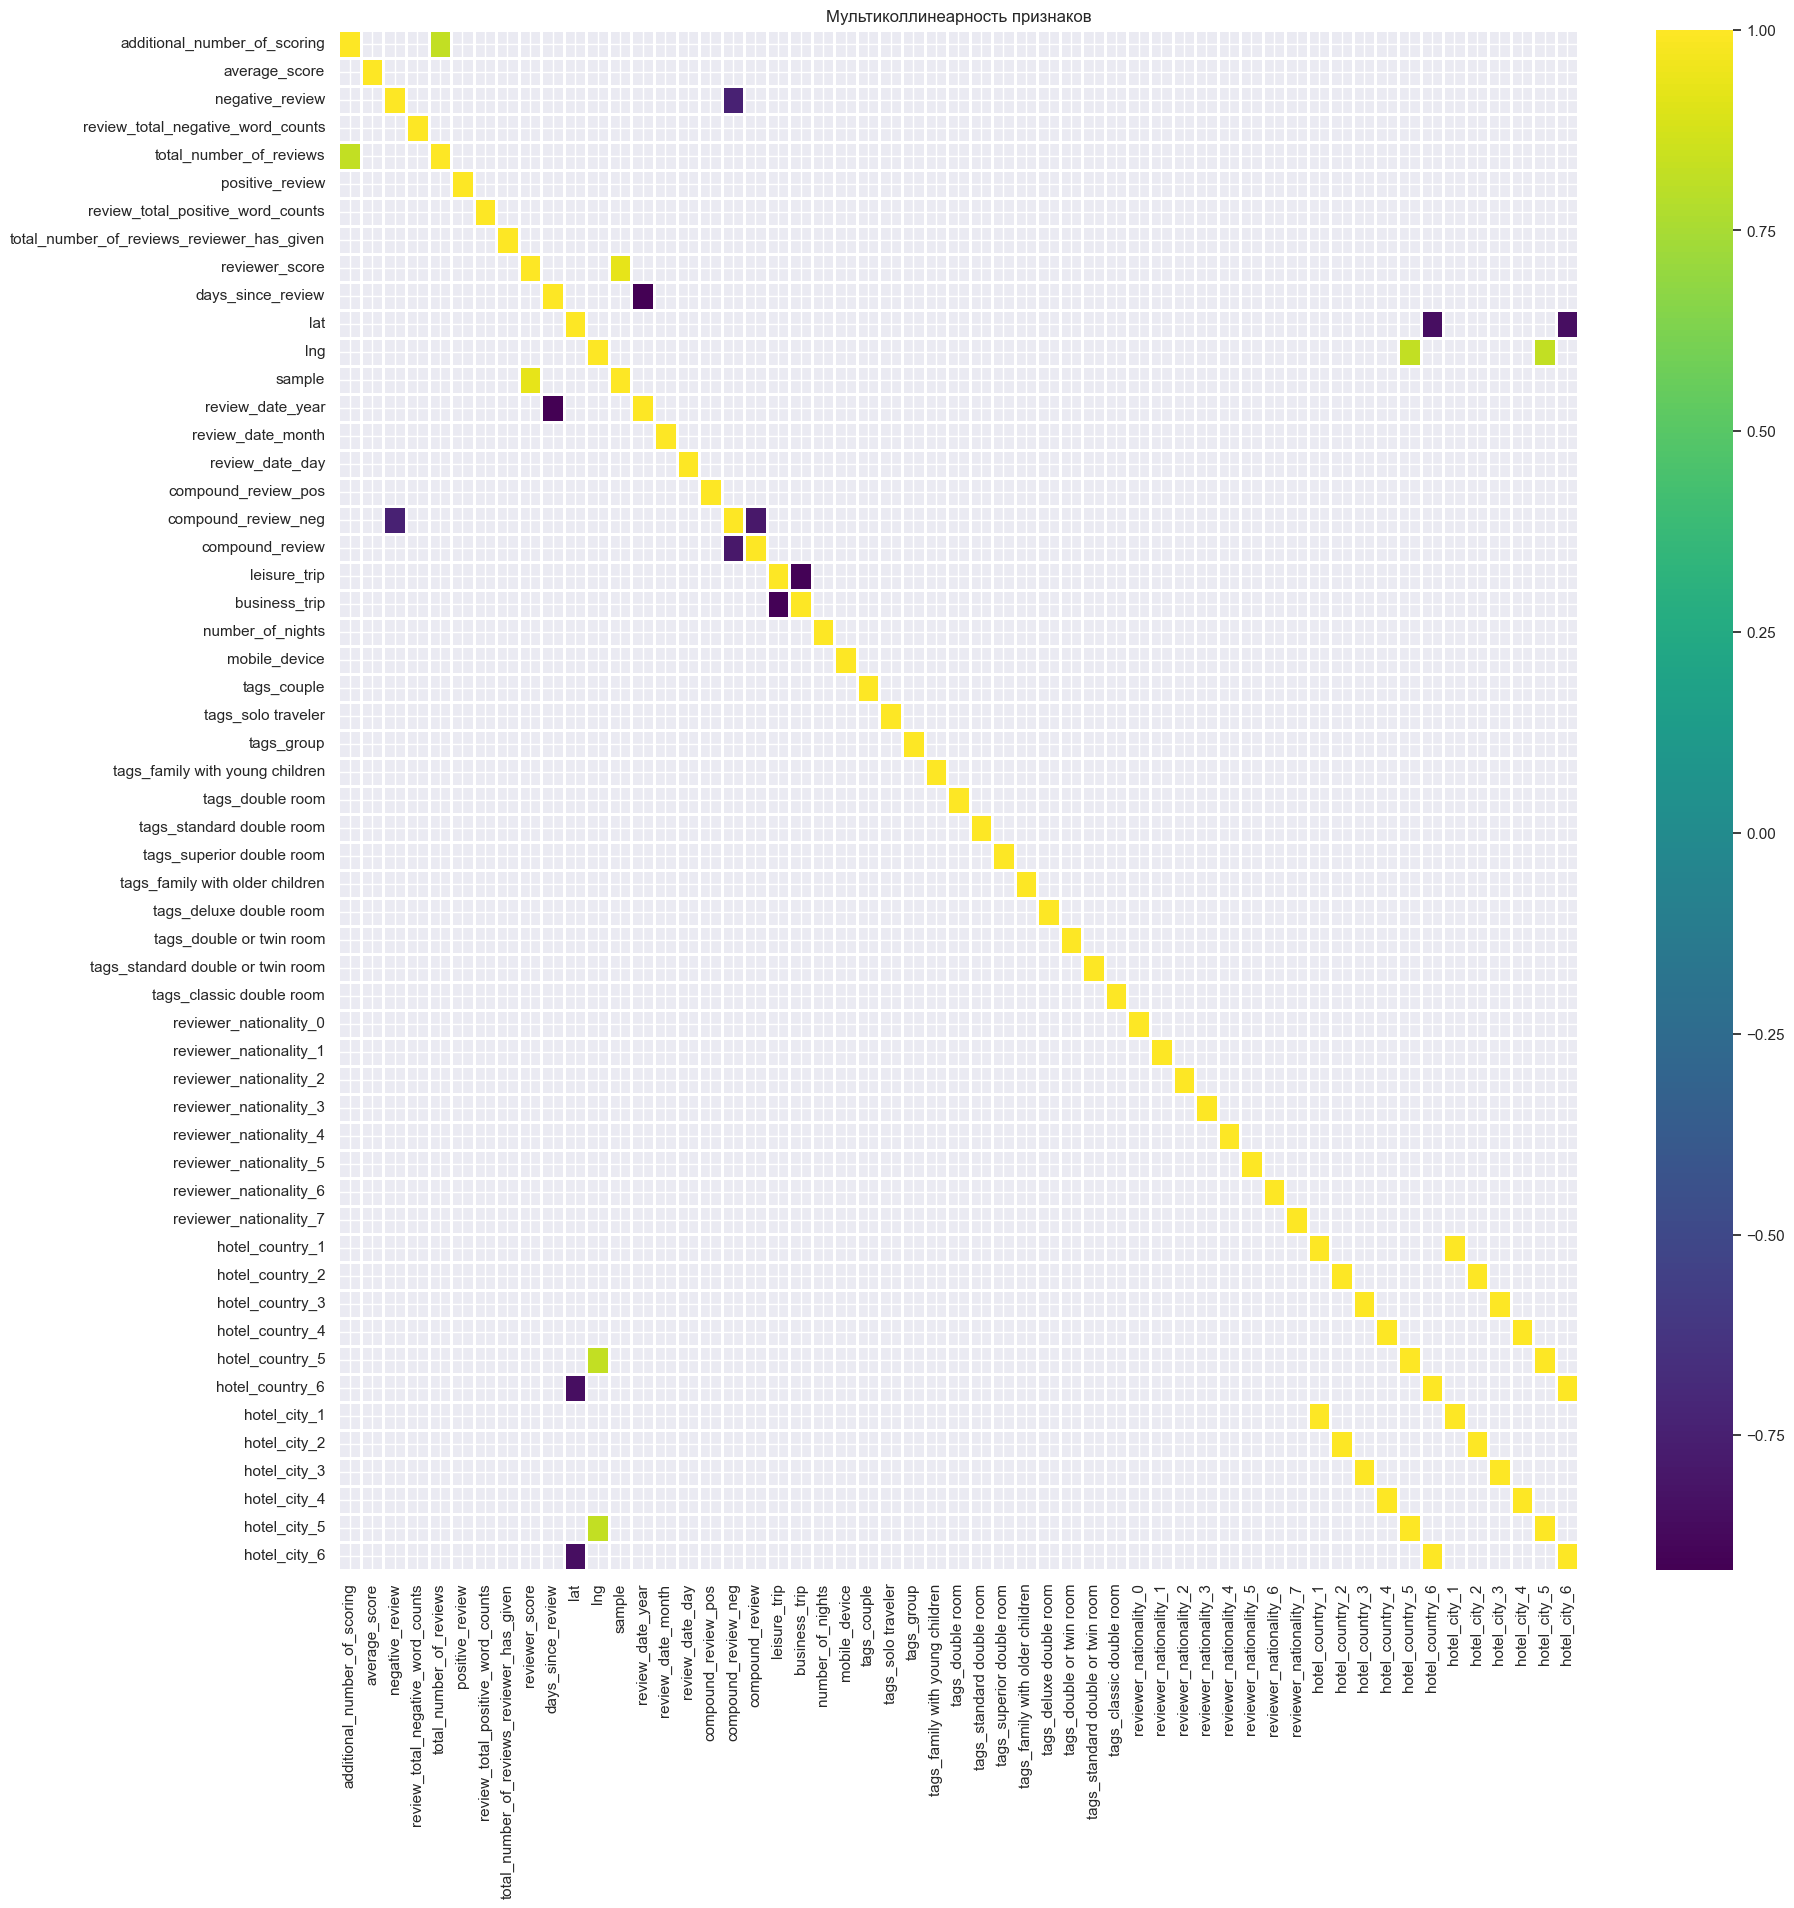

In [199]:
# проверим корреляцию признаков 
corr = hotels.corr()

fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(corr[corr.abs() >= 0.7],  
            linewidths=2, 
            cmap='viridis')

plt.title('Мультиколлинеарность признаков')
fig.show();

In [202]:
# мы видим что признаки страны и города отеля очень сильно коррелируют, избавимся от признаков города
# также уделим другие признаки с сильной корреляцией

hotels = hotels.drop(['hotel_city_1', 'hotel_city_2', 'hotel_city_3', 'hotel_city_4', 'hotel_city_5', 'hotel_city_6', 'lat', 'lng', 'days_since_review', 'business_trip', 'total_number_of_reviews', 'compound_review_neg'], axis = 1)

In [207]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   negative_review                             515431 non-null  float64
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   positive_review                             515431 non-null  float64
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   review_date_year                            515431 non-null  int64  
 

## Оценка значимости признаков

In [208]:
# разделим признаки на 2 группы - категориальные и числовые
hotels.columns

Index(['additional_number_of_scoring', 'average_score', 'negative_review',
       'review_total_negative_word_counts', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'sample', 'review_date_year', 'review_date_month', 'review_date_day',
       'compound_review_pos', 'compound_review', 'leisure_trip',
       'number_of_nights', 'mobile_device', 'tags_couple',
       'tags_solo traveler', 'tags_group', 'tags_family with young children',
       'tags_double room', 'tags_standard double room',
       'tags_superior double room', 'tags_family with older children',
       'tags_deluxe double room', 'tags_double or twin room',
       'tags_standard double or twin room', 'tags_classic double room',
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6

In [214]:
# категориальные признаки
cat_cols = [ 
       'review_date_year', 'review_date_month', 'review_date_day',
       'leisure_trip', 'mobile_device', 'tags_couple',
       'tags_solo traveler', 'tags_group', 'tags_family with young children',
       'tags_double room', 'tags_standard double room',
       'tags_superior double room', 'tags_family with older children',
       'tags_deluxe double room', 'tags_double or twin room',
       'tags_standard double or twin room', 'tags_classic double room',
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'reviewer_nationality_7', 'hotel_country_1',
       'hotel_country_2', 'hotel_country_3', 'hotel_country_4',
       'hotel_country_5', 'hotel_country_6'
]

# числовые (непрерывные) признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'negative_review',
            'review_total_negative_word_counts', 'positive_review','review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'compound_review_pos', 'compound_review',
            'number_of_nights'
]

In [210]:
# разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = hotels.drop(['reviewer_score'], axis = 1)
y = hotels['reviewer_score'].astype('int')

C:\Users\grida\AppData\Local\Temp\ipykernel_16592\3412543334.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


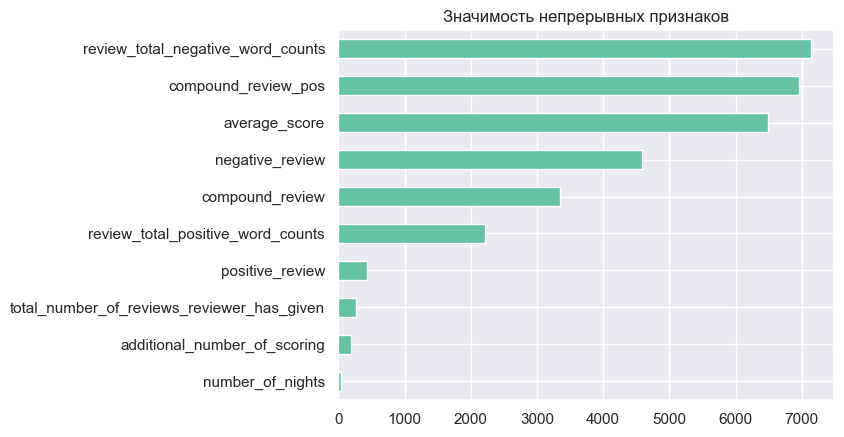

In [212]:
# проверяем значимость непрерывных признаков
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Значимость непрерывных признаков')
fig.show();

C:\Users\grida\AppData\Local\Temp\ipykernel_16592\1960566389.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


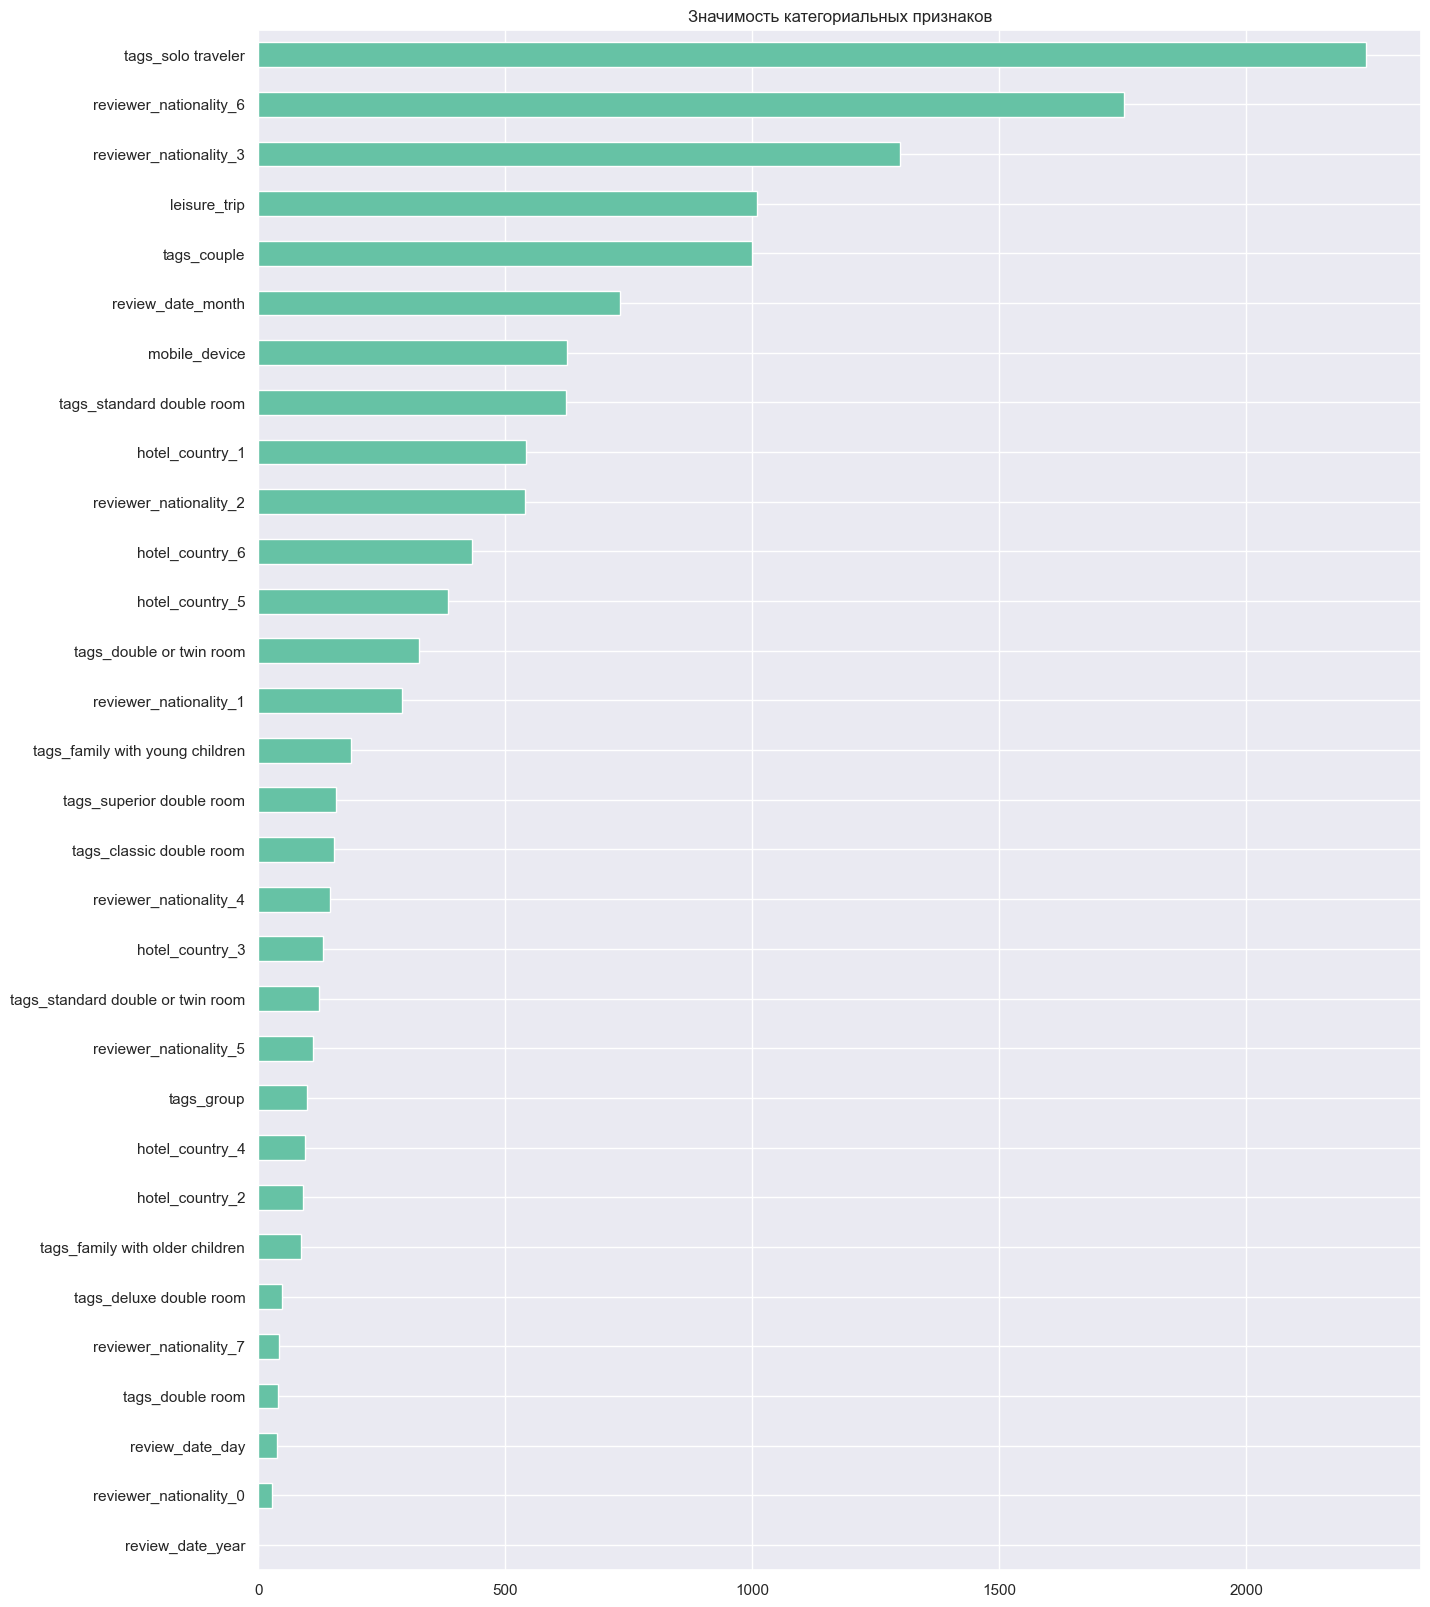

In [216]:
# проверяем значимость категориальных признаков
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
plt.subplots(figsize=(15, 20))
imp_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков')
fig.show();

In [42]:
# избавляемся от наименее значимых признаков
# final_hotels = hotels.drop(['review_date_year', 'season_4', 'tags_stayed 2 nights', 'review_date_day',
                           #'tags_double or twin room', 'tags_deluxe double room', 'season_3', 'tags_stayed 5 nights',
                           #'tags_stayed 4 nights','tags_family with older children', 'hotel_country_2', 
                           #'hotel_country_4', 'tags_group','tags_superior double room','tags_classic double room',
                           #'tags_standard double or twin room'], axis=1)

In [218]:
final_hotels = hotels

# 5.Обучение модели

>Перед нами стоит задача регресси, исходя из этого мы и будем строить модель. Метрику выберем MAPE.

In [220]:
# разделяем данные
hotels_train = final_hotels[final_hotels['sample'] == 1].drop(['sample'], axis=1)
hotels_test = final_hotels[final_hotels['sample'] == 0].drop(['sample'], axis=1)

X = hotels_train.drop(['reviewer_score'], axis=1)
y = hotels_train['reviewer_score'].values

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [222]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 5))

MAPE: 12.53588


В результаты мы получили **MAPE** = 12.53588

C:\Users\grida\AppData\Local\Temp\ipykernel_16592\1850530569.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


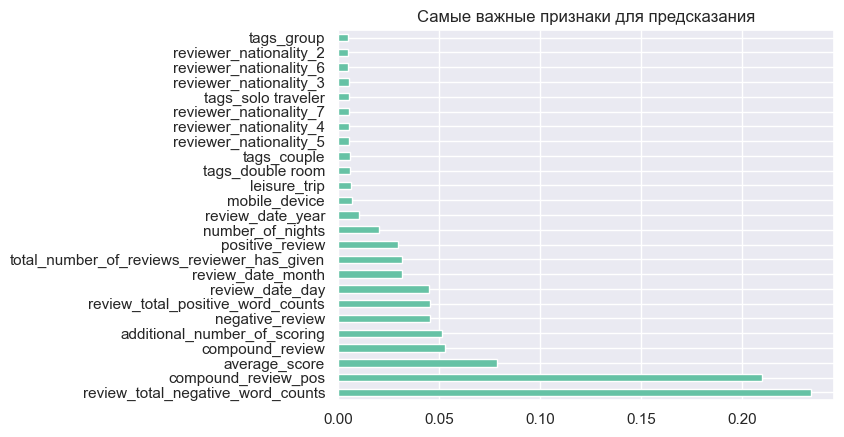

In [223]:
# выводим самые важные признаки для модели
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.title('Самые важные признаки для предсказания')
fig.show()

**Вывод по важнейшим признакам:**
    
    * Наибольшее влияние оказывают признаки связанные с обзорами, число слов в обзоре, оценка(негативная или положительная), также немалое влияние оказал и признак месяца, в который был сделан обзор, что говорит о том, что в первую очередь стоит подробнее разобрать дату отзыва, наряду с вышеперечисленными признаками, и, возможно, улучшить результат.

# 6.Сабмитим результат

In [47]:
hotels_test = hotels_test.drop(['reviewer_score'], axis=1)

In [48]:
predict_submission = regr.predict(hotels_test)

In [49]:
submission['reviewer_score'] = predict_submission
submission.to_csv('submission.csv', index=False)
submission.head(5)

,reviewer_score,id
0,8.469,488440
1,7.678,274649
2,8.487,374688
3,9.808,404352
4,9.593,451596
